In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46159")
client

<Client: 'tcp://127.0.0.1:46159' processes=8 threads=32, memory=123.95 GiB>

In [2]:
import s3fs
import boto3
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
###
import numba
import matplotlib.path as mpath
import pandas as pd
import datetime
import tqdm as tqdm
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Functions 

In [3]:
def odi_map_stretch(n,xmin_map=-165,xmax_map=-125,ymin_map=67.5,ymax_map=80):
    aoi = mpath.Path(
    list(zip(np.linspace(xmin_map,xmax_map, n), np.full(n,ymax_map))) + \
    list(zip(np.full(n,xmax_map), np.linspace(ymax_map,ymin_map, n))) + \
    list(zip(np.linspace(xmax_map,xmin_map, n), np.full(n,ymin_map))) + \
    list(zip(np.full(n,xmin_map), np.linspace(ymin_map,ymax_map, n))))
    return aoi

# Region of interest

In [4]:
lon0=-150
lonmapmin=-180#-160
lonmapmax=-120#-140
latmapmin=65#69
latmapmax=80#75

# Needed path to be used

In [5]:
salt_path   = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SALT_AVG_DAILY.ZARR/'
siarea_path = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SIarea_AVG_DAILY.ZARR/'
theta_path  = 's3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/THETA_AVG_DAILY.ZARR/'

# Acessing data through AWS - profile = sassie

In [6]:
def get_aws_credentials(profile_name='sassie'):
    session = boto3.Session(profile_name=profile_name)
    credentials = session.get_credentials()
    return credentials
#-----------------------------------------------------
# load sassie profile credentials
aws_credentials = get_aws_credentials(profile_name='sassie')
# initialize s3 filesystem
s3_options = dict(anon=False, key=aws_credentials.access_key, secret=aws_credentials.secret_key)
#------------------------------------------------------
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

# Open SALT zarr store

In [ ]:
# open SALT zarr store
SALT_zarr = open_zarr_store(salt_path, s3_options)
SALT_zarr

In [15]:
#-> ECCO model time for the data at hand
ecco_time = SALT_zarr.time

NameError: name 'SALT_zarr' is not defined

In [9]:
# SALT_zarr.SALT[0,0,:,:].plot()

In [10]:
# geom = "s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.ZARR/"
# geom_zarr = open_zarr_store(geom, s3_options)
# # geom_zarr

# Region selection

In [11]:
# Geo area selection
lon_xc = SALT_zarr.XC.values;lat_yc = SALT_zarr.YC.values
geotest = (lon_xc >= lonmapmin) & (lon_xc <= lonmapmax) & (lat_yc >= latmapmin) & (lat_yc <= latmapmax)
geoindex = np.argwhere(geotest)
# Get indexes
xmin = min(geoindex[:,1]);xmax = max(geoindex[:,1])
ymin = min(geoindex[:,0]);ymax = max(geoindex[:,0])
# simple indexes manip.
iid = slice(xmin,xmax);jid = slice(ymin,ymax)
# lon and lad true values in the area of interest
Lon = lon_xc[jid,iid];Lat = lat_yc[jid,iid]

# Point selection

In [12]:
geotest_point = (lon_xc >= -150.5) & (lon_xc <= -150.4) & (lat_yc >= 72.51) & (lat_yc <= 72.565)
geoindex_point = np.argwhere(geotest_point)
xmin_point = min(geoindex_point[:,1]);xmax_point = max(geoindex_point[:,1])
ymin_point = min(geoindex_point[:,0]);ymax_point = max(geoindex_point[:,0])
# simple indexes manip.
iid_point = xmin_point;jid_point = ymin_point
# lon and lad true values in the area of interest
Lon_point = lon_xc[jid_point,iid_point];Lat_point = lat_yc[jid_point,iid_point]

### Fast look on salinity

In [13]:
# sal = SALT_zarr.SALT[0,0,:,:]
# sal[jid,iid].plot(cmap='jet')
# plt.grid(alpha=0.5)

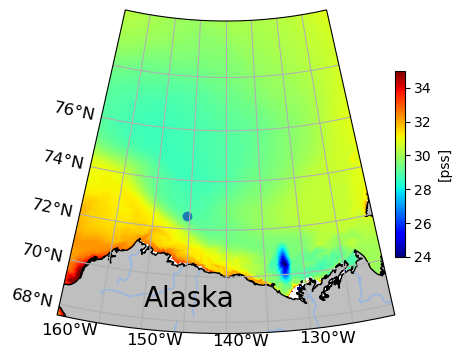

In [14]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
sal = SALT_zarr.SALT[0,0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,sal,cmap='jet',vmin=24,vmax=35,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[pss]')

plt.plot(Lon_point,Lat_point,'o',transform=ccrs.PlateCarree())
# plt.savefig("Fig/SSS_1st_map_Beaufort_Sea.png")

# Open SIarea zarr store

In [15]:
# open SIarea zarr store
SIarea_zarr = open_zarr_store(siarea_path, s3_options)
SIarea_zarr

<xarray.Dataset> Size: 40GB
Dimensions:    (time: 2581, j: 1080, i: 1800, nv: 2)
Coordinates:
    XC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
  * i          (i) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * j          (j) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB dask.array<chunksize=(2581, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SIarea     (time, j, i) float64 40GB dask.array<chunksize=(1, 270, 450), meta=np.ndarray>
Attributes: (12/50)
    Conventions:               CF-1.8, ACDD-1.3
    acknowledgement:           This research was carried out by the Jet Propu...
    author:                    Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:             Grid
    comment:                   SASSIE llc1080 V1R1 fields are consolidated on...
    creator_email:             ecco-group@mit.edu
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset provides data variable and geomet...
    time_coverage_end:         2021-02-08T00:00:00
    time_coverage_start:       2014-01-15T00:00:00
    title:                     SASSIE Ocean Model SIarea Parameter for the La...
    uuid:                      38daf79a-12d4-11ef-becf-0604868e061f

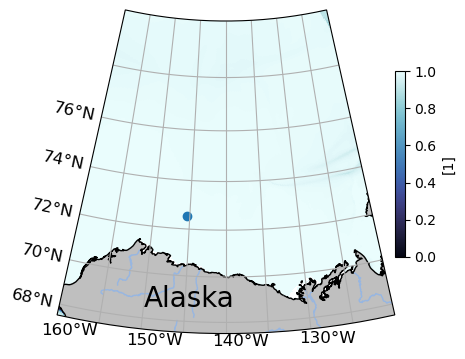

In [16]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
sic = SIarea_zarr.SIarea[0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,sic,cmap='cmo.ice',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[1]')

plt.plot(Lon_point,Lat_point,'o',transform=ccrs.PlateCarree())
# plt.savefig("Fig/SIC_1st_map_Beaufort_Sea.png")

# Open THETA zarr store

In [17]:
# open THETA zarr store
theta_zarr = open_zarr_store(theta_path, s3_options)
theta_zarr

<xarray.Dataset> Size: 4TB
Dimensions:    (time: 2581, k: 90, j: 1080, i: 1800, k_l: 90, k_p1: 91,
                k_u: 90, nv: 2)
Coordinates: (12/14)
    XC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(270, 450), meta=np.ndarray>
    Z          (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zl         (k_l) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Zp1        (k_p1) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    Zu         (k_u) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    ...         ...
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB dask.array<chunksize=(2581, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    THETA      (time, k, j, i) float64 4TB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:                   Grid
    comment:                         SASSIE llc1080 V1R1 fields are consolida...
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides data variable and ...
    time_coverage_end:               2021-02-08T00:00:00
    time_coverage_start:             2014-01-15T00:00:00
    title:                           SASSIE Ocean Model THETA Parameter for t...
    uuid:                            92f116d8-13ba-11ef-9cf8-0604868e061f

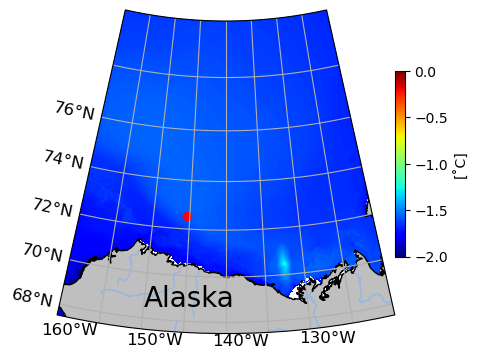

In [18]:
## Map View Using Cartopy
fig = plt.figure(figsize=(6,4))
xmin_map=-165;xmax_map=-125;ymin_map=67.5;ymax_map=80
proj = ccrs.LambertConformal(central_longitude=(xmin_map+xmax_map)/2, central_latitude=(ymin_map+ymax_map)/2)
ax = fig.add_subplot(1, 1, 1, projection=proj);aoi = odi_map_stretch(n=20)
ax.set_boundary(aoi, transform=ccrs.PlateCarree());ax.add_feature(cfeature.LAND, facecolor = '0.75')
ax.add_feature(cfeature.RIVERS,facecolor='blue');ax.coastlines('10m')
ax.set_extent([xmin_map,xmax_map,ymin_map,ymax_map],crs=ccrs.PlateCarree())
# Set gridlines to variable so you can manipulate them
gl = ax.gridlines(draw_labels=False,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False)
# gl.xlocator = mticker.FixedLocator(np.arange(xmin_map,xmax_map+1,5))
# gl.ylocator = mticker.FixedLocator(np.arange(ymin_map+.5,ymax_map+1,2))
gl.xformatter = LONGITUDE_FORMATTER;gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0};gl.ylabel_style = {'size': 12, 'color': 'k'}#,'rotation':0}
gl.bottom_labels = True; gl.top_labels = False;gl.right_labels = False;gl.left_labels = True
ax.text(-155,68.5,'Alaska', fontsize=20,transform=ccrs.PlateCarree())
#-------------------------------------------------------------------#
temp = theta_zarr.THETA[0,0,jid,iid].squeeze()
# sal[jid,iid].plot(cmap='jet')
cb = ax.pcolormesh(Lon,Lat,temp,cmap='jet',vmin=-2,vmax=0,transform=ccrs.PlateCarree())
cbar = plt.colorbar(cb,fraction=0.02, pad=0.001, orientation="vertical",shrink=0.75,label='[˚C]')
plt.plot(Lon_point,Lat_point,'ro',transform=ccrs.PlateCarree())
# plt.savefig("Fig/SST_1st_map_Beaufort_Sea.png")

# Getting variable in the area of interest

In [19]:
#-> salinity
sal_intt  = SALT_zarr.SALT.isel(j=jid_point,i=iid_point)
sal_intt

<xarray.DataArray 'SALT' (time: 2581, k: 90)> Size: 2MB
dask.array<getitem, shape=(2581, 90), dtype=float64, chunksize=(1, 15), chunktype=numpy.ndarray>
Coordinates:
    XC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    YC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    Z        (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    i        int32 4B 577
    j        int32 4B 332
  * k        (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T12...
Attributes:
    comment:                Defined using CF convention 'Sea water salinity i...
    coverage_content_type:  modelResult
    long_name:              Salinity
    standard_name:          sea_water_salinity
    units:                  1e-3

In [20]:
sal_0 = sal_intt.isel(k=0)

In [21]:
# sal_intt  = SALT_zarr.SALT.isel(i=577,j=332)

In [22]:
#-> potential temperature
temp_intt = theta_zarr.THETA.isel(j=jid_point,i=iid_point)
temp_intt

<xarray.DataArray 'THETA' (time: 2581, k: 90)> Size: 2MB
dask.array<getitem, shape=(2581, 90), dtype=float64, chunksize=(1, 15), chunktype=numpy.ndarray>
Coordinates:
    XC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    YC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    Z        (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    i        int32 4B 577
    j        int32 4B 332
  * k        (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T12...
Attributes:
    comment:                Sea water potential temperature is the temperatur...
    coverage_content_type:  modelResult
    long_name:              Potential temperature 
    standard_name:          sea_water_potential_temperature
    units:                  degree_C

In [23]:
temp_0 = temp_intt.isel(k=0)

# -> sea ice concentration [1]

In [24]:
sic_intt  = SIarea_zarr.SIarea.isel(j=jid_point,i=iid_point)
sic_intt

<xarray.DataArray 'SIarea' (time: 2581)> Size: 21kB
dask.array<getitem, shape=(2581,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    YC       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    i        int32 4B 577
    j        int32 4B 332
  * time     (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T12...
Attributes:
    comment:                Fraction of ocean grid cell covered with sea-ice ...
    coverage_content_type:  modelResult
    long_name:              Sea-ice concentration
    standard_name:          sea_ice_area_fraction
    units:                  1

# Slection of Sea Ice formation periods
- Here, we chose: Sept. 1st to dec 31st as a targeted period of sea ice formation in the Beaufort Sea
  - for: 2014, 2015, 2016, 2017, 2018, 2019 and 2020

In [25]:
time_string = []
for i in np.arange(ecco_time.size):
    time_string.append(str(ecco_time.values[i])[slice(0,10,1)])

In [26]:
anne = np.arange(2014,2021,1)
indexIcePeriod = np.array([])
indexIcePeriod2 = {}
for i in np.arange(anne.size):
    id1 = np.datetime64(str(anne[i])+'-09-01T00:00:00Z','ns')
    id2 = np.datetime64(str(anne[i])+'-12-31T00:00:00Z','ns')
    idIcePeriod = np.where((ecco_time.values>=id1) & (ecco_time.values<=id2))[0]
    indexIcePeriod = np.concatenate((indexIcePeriod,idIcePeriod),axis=0)
    indexIcePeriod2.update({str(anne[i]):idIcePeriod})

In [27]:
# day of year for ploting purpose 
time_plot_dayOfYear = np.array(ecco_time[indexIcePeriod2["2014"]].dt.dayofyear)
# time sel length#
t_IFP_length = time_plot_dayOfYear.size
time_plot_dayOfYear

array([244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
       322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
       335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
       348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360,
       361, 362, 363, 364])

# Computing the sea ice formation date map for the fall-winter of 2014

In [28]:
sic = np.array(sic_intt)

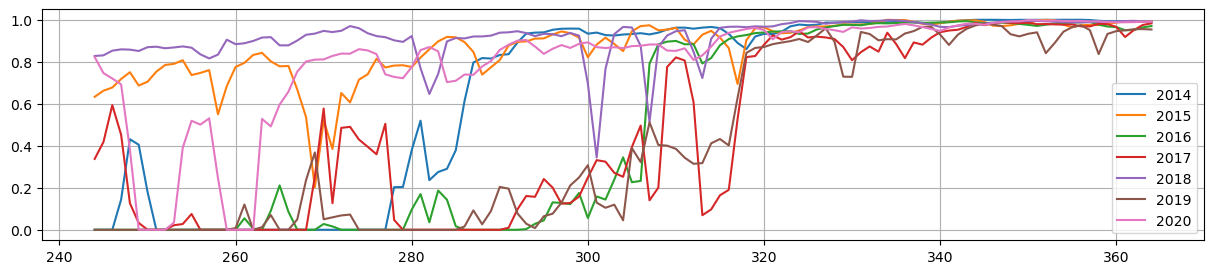

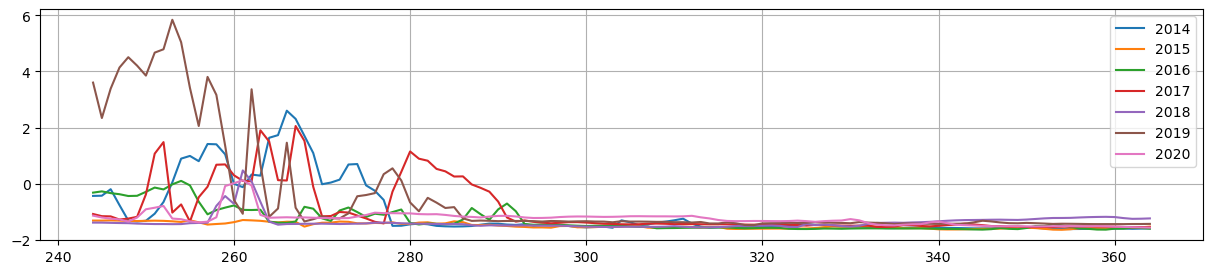

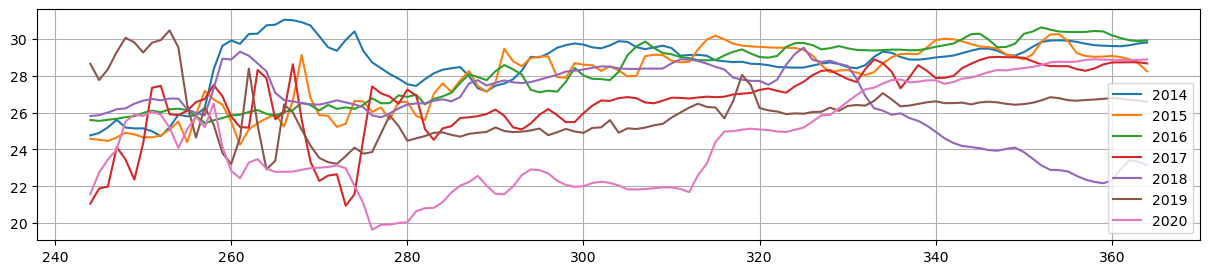

In [76]:
fig = plt.figure(figsize=[15,3], num=1);plt.clf();
for i in anne:
    plt.plot(time_plot_dayOfYear,sic[indexIcePeriod2[str(i)]],'-',label=str(i))
plt.legend()
plt.grid()
fig = plt.figure(figsize=[15,3]);plt.clf();
for i in anne:
    plt.plot(time_plot_dayOfYear,temp_0[indexIcePeriod2[str(i)]],'-',label=str(i))
plt.legend()
plt.grid()
fig = plt.figure(figsize=[15,3]);plt.clf();
for i in anne:
    plt.plot(time_plot_dayOfYear,sal_0[indexIcePeriod2[str(i)]],'-',label=str(i))
plt.legend()
plt.grid()

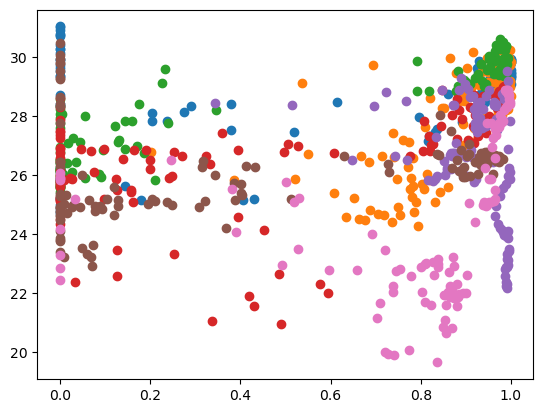

In [30]:
for i in anne:
    plt.plot(sic[indexIcePeriod2[str(i)]],sal_0[indexIcePeriod2[str(i)]],'o')

# Selection of ice formation period

In [68]:
SIC_IFP  = SIarea_zarr.isel(time=indexIcePeriod.astype(int),i=iid,j=jid).to_array(dim='SIarea').squeeze()
SAL_IFP  = SALT_zarr.isel(time=indexIcePeriod.astype(int),i=iid,j=jid).to_array(dim='SALT').squeeze()
TEMP_IFP = theta_zarr.isel(time=indexIcePeriod.astype(int),i=iid,j=jid).to_array(dim='THETA').squeeze()

In [32]:
# TEMP_IFP

In [69]:
SIC_IFP

<xarray.DataArray (time: 847, j: 619, i: 527)> Size: 2GB
dask.array<getitem, shape=(847, 619, 527), dtype=float64, chunksize=(1, 270, 429), chunktype=numpy.ndarray>
Coordinates:
    XC         (j, i) float32 1MB dask.array<chunksize=(270, 98), meta=np.ndarray>
    YC         (j, i) float32 1MB dask.array<chunksize=(270, 98), meta=np.ndarray>
  * i          (i) int32 2kB 352 353 354 355 356 357 ... 873 874 875 876 877 878
  * j          (j) int32 2kB 0 1 2 3 4 5 6 7 ... 611 612 613 614 615 616 617 618
  * time       (time) datetime64[ns] 7kB 2014-09-01T12:00:00 ... 2020-12-30T1...
    time_bnds  (time, nv) datetime64[ns] 14kB dask.array<chunksize=(847, 2), meta=np.ndarray>
    SIarea     <U6 24B 'SIarea'
Attributes: (12/50)
    Conventions:               CF-1.8, ACDD-1.3
    acknowledgement:           This research was carried out by the Jet Propu...
    author:                    Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:             Grid
    comment:                   SASSIE llc1080 V1R1 fields are consolidated on...
    creator_email:             ecco-group@mit.edu
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset provides data variable and geomet...
    time_coverage_end:         2021-02-08T00:00:00
    time_coverage_start:       2014-01-15T00:00:00
    title:                     SASSIE Ocean Model SIarea Parameter for the La...
    uuid:                      38daf79a-12d4-11ef-becf-0604868e061f

In [71]:
A = SIC_IFP.groupby('time.year').std()

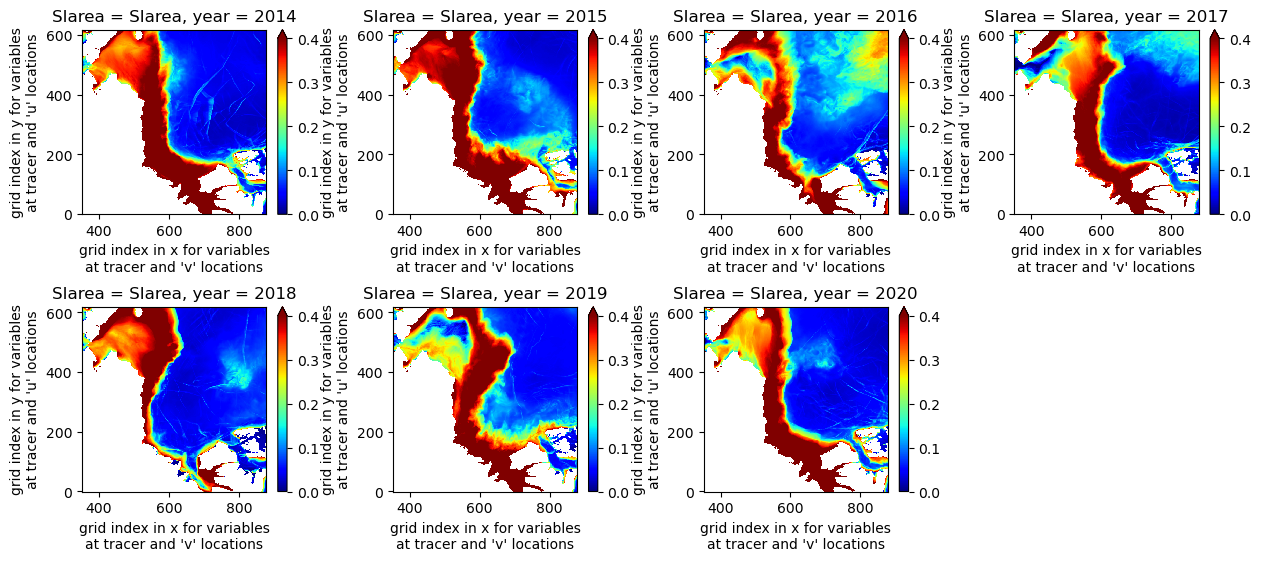

In [81]:
fig = plt.figure(figsize=[15,6], num=1);plt.clf();
fig.subplots_adjust(wspace=0.35)
fig.subplots_adjust(hspace=0.5)
for i in np.arange(7):
    plt.subplot(2,4,i+1)
    A[i,:,:].plot(vmin=0,vmax=0.4,cmap='jet')
plt.savefig("../Fig/SIC_Beaufort_Sea-STD-of-SIFP.png")

In [82]:
B = SIC_IFP.groupby('time.year').mean()

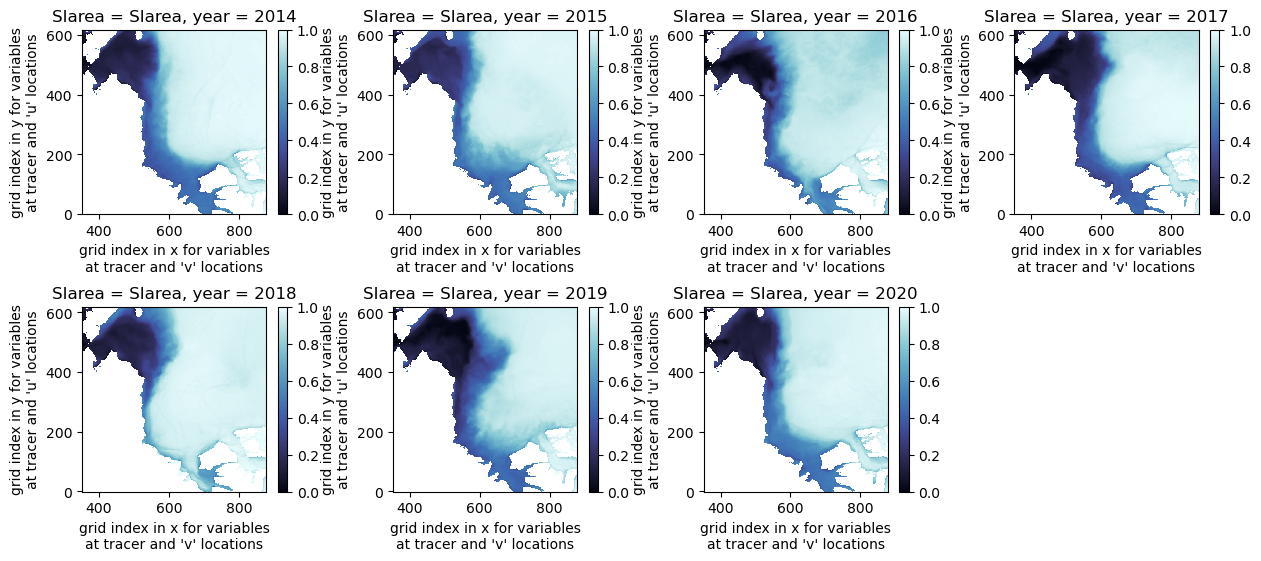

In [87]:
fig = plt.figure(figsize=[15,6], num=1);plt.clf();
fig.subplots_adjust(wspace=0.35)
fig.subplots_adjust(hspace=0.5)
for i in np.arange(7):
    plt.subplot(2,4,i+1)
    B[i,:,:].plot(vmin=0,vmax=1,cmap='cmo.ice')
plt.savefig("../Fig/SIC_Beaufort_Sea-MEAN-of-SIFP.png")

In [88]:
tnbr,knbr,jnbr,inbr = TEMP_IFP.shape
nYear = tnbr//t_IFP_length
nYear,t_IFP_length,knbr,jnbr,inbr

(7, 121, 90, 619, 527)

In [89]:
anne

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [35]:
# nYear = tnbr//t_IFP_length
# A = np.reshape(TEMP_IFP.values,(nYear,t_IFP_length,knbr,jnbr,inbr))
stop here!

SyntaxError: invalid syntax (3131282936.py, line 3)

In [ ]:
RangeSel = np.arange(SIC_IFP.shape[0]).reshape((121,7),order='F')
for i in tqdm.tqdm(np.arange(7)):
    if i==0:
        PSAL = np.array(SAL_IFP.isel(time=RangeSel[:,i]))
        Temp = np.array(TEMP_IFP.isel(time=RangeSel[:,i]))
        SICs = np.array(SIC_IFP.isel(time=RangeSel[:,i]))
    else:
        PSAL = np.stack((PSAL,np.array(SAL_IFP.isel(time=RangeSel[:,i]))))
        Temp = np.stack((Temp,np.array(TEMP_IFP.isel(time=RangeSel[:,i]))))
        SICs = np.stack((SICs,np.array(SIC_IFP.isel(time=RangeSel[:,i]))))

 14%|██████████████████████▏                                                                                                                                    | 1/7 [02:57<17:45, 177.65s/it]

In [ ]:
# help(np.dstack)
# indexIcePeriod2.keys()#[str(i)]
SICs.shape

In [92]:
B = np.array(SIC_IFP.isel(time=indexIcePeriod2[str(2014)]))

In [98]:
np.stack((B,B)).shape

(2, 121, 619, 527)

In [102]:
# indexIcePeriod2[str(2014)]
SIC_IFP.shape[0]

847

In [110]:
RangeSel = np.arange(SIC_IFP.shape[0]).reshape((121,7),order='F')
RangeSel[:,0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120])